In [1]:
%matplotlib inline

In [2]:
# HACK: needed to manually import sys.path from ipython repl, for some reason it doesn't work on my host otherwise
import sys
sys.path = ['', '/Users/naveed/scratch/fraud_detection_project/venv/bin', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python27.zip', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-darwin', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-mac', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-tk', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-old', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-dynload', '/Users/naveed/anaconda2/lib/python2.7', '/Users/naveed/anaconda2/lib/python2.7/plat-darwin', '/Users/naveed/anaconda2/lib/python2.7/lib-tk', '/Users/naveed/anaconda2/lib/python2.7/plat-mac', '/Users/naveed/anaconda2/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/IPython/extensions', '/Users/naveed/.ipython']

In [39]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import xgboost
from imblearn_random_sample import RandomUnderSampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
pd.set_option('max_colwidth', -1)

In [41]:
pdf = pd.read_csv('./creditcard.csv')

# Notes:
 - Reduced FeatureSet: 28 Features determined from prior PCA analysis. Original features were scrubbed for user anonymity
 - Time & Amount are the only two original features
 - Total Samples in DataSet: 284,807. Number of Fraudalent transactions: 492 (0.172%) of all transactions. Represented by "Class" Feature
 
# Goal:
 - with the highly imbalanced data set, normalize the data by undersampling / oversampling the data
 - compare different models and estimate which ones perform better
 - go back and use some oversampling method to see how the models change with the availability of more data

In [6]:
numerical_features_only = sorted(list(set(pdf.columns.tolist()) - set(['Time', 'Amount', 'Class'])), key=lambda x: int(x[1:]))

## Data Preparation
- Dealing with imbalanced data seems to be a concern here because of the disparity of fraudalent data
    - Oversampling — SMOTE
    - Undersampling — RandomUnderSampler
    - Combined Class Methods — SMOTE + ENN
- Outlier Detection & Removal
- Dimensionality Reduction

In [7]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

pdf['time_normalized'] = normalize(pdf.Time)
pdf['amount_normalized'] = normalize(pdf.Amount)

### Split dataset into training / test

In [10]:
features = [x for x in pdf.columns.tolist() if x not in ['Class', 'Time', 'Amount']]

X = pdf[features]
y = pdf.Class

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.8, random_state=0)

In [11]:
results = pd.DataFrame()

col_order = ['false_negative', 'false_positive', 'true_negative', 'true_positive', 'fraud_f1-score', 'fraud_precision', 'fraud_recall', 'not_fraud_f1-score', 'not_fraud_precision', 'not_fraud_recall']

## Helper methods for model creation

In [12]:
def train_model(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {model_name} on test set: {accuracy:.2f}'.format(model_name=model_name, accuracy=model.score(X_test, y_test)))
    
    return y_pred

def flatten(report):
    "used to flatten confusion matrix and classification report "
    final_dict = {}
    for k, v in report.items():
        for k2, v2 in v.items():
            if k2 in ['precision', 'recall', 'f1-score'] and k in ['not_fraud', 'fraud']:
                final_dict[k + '_' +k2] =  v2
    
    return final_dict

def analyze_model_stats(model, model_name, X_train, X_test, y_train, y_test, y_pred, results_df):
    cfmx = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud'], output_dict=True)
    
    print 'CONFUSION MATRIX:\n',
    print(cfmx)
    print
    print 'CLASSIFICATION REPORT:'
    print(classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud']))
        
    data = dict({
        'name': model_name,
        'true_positive': cfmx[0,0],
        'false_negative': cfmx[0,1],
        'false_positive': cfmx[1,0],
        'true_negative': cfmx[1,1],
    }, **flatten(report))
    
    return [data]
    
def train_and_analyze(model, model_name, X_train, X_test, y_train, y_test, results_df):
    y_pred = train_model(model, model_name, X_train, X_test, y_train, y_test)
    return analyze_model_stats(model, model_name, X_train, X_test, y_train, y_test, y_pred, results_df)

## ML Models to try out
- [**DONE**] Logistic Regression
- [**DONE**] Linear Discriminant Analysis
- [**DONE**] K Nearest Neighbors (KNN)
- [**DONE**] Classification Trees (Decision Tree, Random Forest)
- [**DONE**]Support Vector Classifier
- [**DONE**] Random Forest Classifier
- [**DONE**] XGBoost Classifier (could not get this thing to compile -- try again later)

## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
results = results.append(train_and_analyze(logreg, 'logistic regression', X_train, X_test, y_train, y_test, results))

Accuracy of logistic regression on test set: 0.93
CONFUSION MATRIX:
[[383   9]
 [ 49 347]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.89      0.98      0.93       392
       fraud       0.97      0.88      0.92       396

   micro avg       0.93      0.93      0.93       788
   macro avg       0.93      0.93      0.93       788
weighted avg       0.93      0.93      0.93       788



/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,9,49,347,383,0.922872,0.974719,0.876263,0.929612,0.886574,0.977041


## Linear Discriminant Analysis

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [16]:
lindisc = LinearDiscriminantAnalysis()
results = results.append(train_and_analyze(lindisc, 'linear discriminant', X_train, X_test, y_train, y_test, results))

Accuracy of linear discriminant on test set: 0.88
CONFUSION MATRIX:
[[376  16]
 [ 80 316]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.82      0.96      0.89       392
       fraud       0.95      0.80      0.87       396

   micro avg       0.88      0.88      0.88       788
   macro avg       0.89      0.88      0.88       788
weighted avg       0.89      0.88      0.88       788



In [17]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,9,49,347,383,0.922872,0.974719,0.876263,0.929612,0.886574,0.977041
linear discriminant,16,80,316,376,0.868132,0.951807,0.797980,0.886792,0.824561,0.959184


## K Nearest Neighbors (KNN)

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
neigh = KNeighborsClassifier(n_neighbors=2)
results = results.append(train_and_analyze(neigh, 'k nearest neighbors', X_train, X_test, y_train, y_test, results))

Accuracy of k nearest neighbors on test set: 0.90
CONFUSION MATRIX:
[[392   0]
 [ 78 318]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.83      1.00      0.91       392
       fraud       1.00      0.80      0.89       396

   micro avg       0.90      0.90      0.90       788
   macro avg       0.92      0.90      0.90       788
weighted avg       0.92      0.90      0.90       788



In [20]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,9,49,347,383,0.922872,0.974719,0.876263,0.929612,0.886574,0.977041
linear discriminant,16,80,316,376,0.868132,0.951807,0.797980,0.886792,0.824561,0.959184
k nearest neighbors,0,78,318,392,0.890756,1.000000,0.803030,0.909513,0.834043,1.000000


## Classification Trees

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
dectree = DecisionTreeClassifier()
results = results.append(train_and_analyze(dectree, 'decision tree', X_train, X_test, y_train, y_test, results))

Accuracy of decision tree on test set: 0.88
CONFUSION MATRIX:
[[370  22]
 [ 69 327]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.84      0.94      0.89       392
       fraud       0.94      0.83      0.88       396

   micro avg       0.88      0.88      0.88       788
   macro avg       0.89      0.88      0.88       788
weighted avg       0.89      0.88      0.88       788



In [23]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,9,49,347,383,0.922872,0.974719,0.876263,0.929612,0.886574,0.977041
linear discriminant,16,80,316,376,0.868132,0.951807,0.797980,0.886792,0.824561,0.959184
k nearest neighbors,0,78,318,392,0.890756,1.000000,0.803030,0.909513,0.834043,1.000000
decision tree,22,69,327,370,0.877852,0.936963,0.825758,0.890493,0.842825,0.943878


## Support Vector Classification

In [24]:
from sklearn import svm

In [25]:
clf = svm.SVC(kernel='rbf', C=1, gamma=0.001, random_state=1)
results = results.append(train_and_analyze(clf, 'support vectors', X_train, X_test, y_train, y_test, results))

Accuracy of support vectors on test set: 0.91
CONFUSION MATRIX:
[[392   0]
 [ 74 322]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.84      1.00      0.91       392
       fraud       1.00      0.81      0.90       396

   micro avg       0.91      0.91      0.91       788
   macro avg       0.92      0.91      0.91       788
weighted avg       0.92      0.91      0.91       788



In [26]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,9,49,347,383,0.922872,0.974719,0.876263,0.929612,0.886574,0.977041
linear discriminant,16,80,316,376,0.868132,0.951807,0.797980,0.886792,0.824561,0.959184
k nearest neighbors,0,78,318,392,0.890756,1.000000,0.803030,0.909513,0.834043,1.000000
decision tree,22,69,327,370,0.877852,0.936963,0.825758,0.890493,0.842825,0.943878
support vectors,0,74,322,392,0.896936,1.000000,0.813131,0.913753,0.841202,1.000000


## Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rdm = RandomForestClassifier()
results = results.append(train_and_analyze(rdm, 'random forest', X_train, X_test, y_train, y_test, results))

Accuracy of random forest on test set: 0.91
CONFUSION MATRIX:
[[386   6]
 [ 63 333]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.86      0.98      0.92       392
       fraud       0.98      0.84      0.91       396

   micro avg       0.91      0.91      0.91       788
   macro avg       0.92      0.91      0.91       788
weighted avg       0.92      0.91      0.91       788



/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [29]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,9,49,347,383,0.922872,0.974719,0.876263,0.929612,0.886574,0.977041
linear discriminant,16,80,316,376,0.868132,0.951807,0.797980,0.886792,0.824561,0.959184
k nearest neighbors,0,78,318,392,0.890756,1.000000,0.803030,0.909513,0.834043,1.000000
decision tree,22,69,327,370,0.877852,0.936963,0.825758,0.890493,0.842825,0.943878
support vectors,0,74,322,392,0.896936,1.000000,0.813131,0.913753,0.841202,1.000000
random forest,6,63,333,386,0.906122,0.982301,0.840909,0.917955,0.859688,0.984694


## XGBoost Classifier

In [30]:
from xgboost import XGBClassifier

In [31]:
xgb = XGBClassifier()
results = results.append(train_and_analyze(xgb, 'XGBoost', X_train, X_test, y_train, y_test, results))

Accuracy of XGBoost on test set: 0.91
CONFUSION MATRIX:
[[383   9]
 [ 58 338]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.87      0.98      0.92       392
       fraud       0.97      0.85      0.91       396

   micro avg       0.91      0.91      0.91       788
   macro avg       0.92      0.92      0.91       788
weighted avg       0.92      0.91      0.91       788



In [32]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,9,49,347,383,0.922872,0.974719,0.876263,0.929612,0.886574,0.977041
linear discriminant,16,80,316,376,0.868132,0.951807,0.797980,0.886792,0.824561,0.959184
k nearest neighbors,0,78,318,392,0.890756,1.000000,0.803030,0.909513,0.834043,1.000000
decision tree,22,69,327,370,0.877852,0.936963,0.825758,0.890493,0.842825,0.943878
support vectors,0,74,322,392,0.896936,1.000000,0.813131,0.913753,0.841202,1.000000
random forest,6,63,333,386,0.906122,0.982301,0.840909,0.917955,0.859688,0.984694
XGBoost,9,58,338,383,0.909825,0.974063,0.853535,0.919568,0.868481,0.977041


In [33]:
blah = results.copy()
blah.set_index('name', inplace=True)
blah['false_negative_normalized'] = normalize(blah['false_negative'])

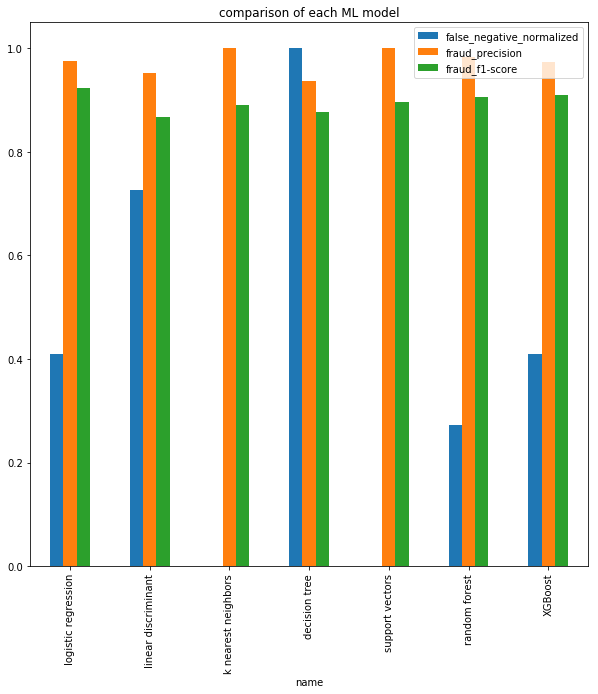

In [34]:
model_viz = blah[['false_negative_normalized', 'fraud_precision', 'fraud_f1-score']].plot(kind='bar', title='comparison of each ML model', figsize=(10,10))

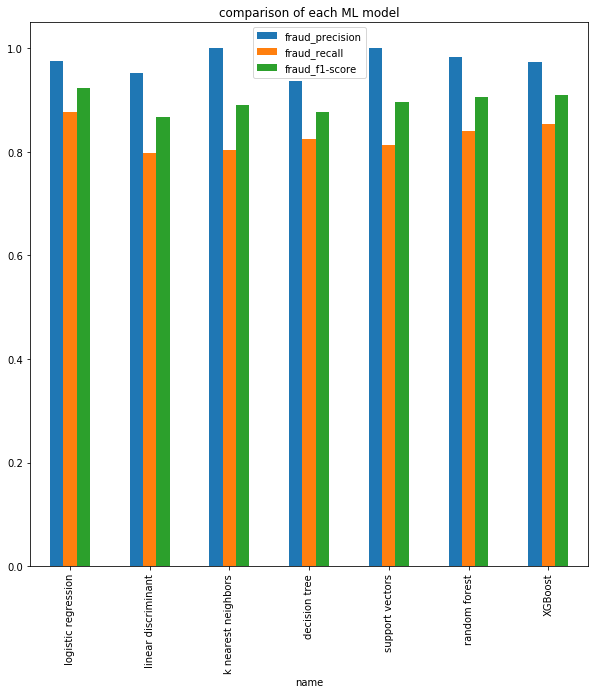

In [35]:
model_viz = blah[['fraud_precision', 'fraud_recall', 'fraud_f1-score']].plot(kind='bar', title='comparison of each ML model', figsize=(10,10))

In [43]:
blah[['fraud_precision', 'fraud_recall', 'fraud_f1-score']].sort_values('fraud_precision', ascending=False)

,fraud_precision,fraud_recall,fraud_f1-score
name,,,
k nearest neighbors,1.000000,0.803030,0.890756
support vectors,1.000000,0.813131,0.896936
random forest,0.982301,0.840909,0.906122
logistic regression,0.974719,0.876263,0.922872
XGBoost,0.974063,0.853535,0.909825
linear discriminant,0.951807,0.797980,0.868132
decision tree,0.936963,0.825758,0.877852


In [37]:
results.to_pickle('./results/undersample.pkl')

## Undersampling write-up 